In [26]:
# Initial report setup.
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import re
from datetime import datetime

# Capstone for Thinkful - Data Science Bootcamp


## Data source
Data source selected in the report is [Open Food Facts](https://www.kaggle.com/openfoodfacts/world-food-facts/data). An open and collaborative database of food products from around the world containing information from product labels visible packages. 

It contains over 100 000 products from over 150 countries around the world. And it's been contributed to by over 5000 individuals.

Among other things, it contains:
 - Countries where the product is sold (`countries_en`)
 - Amount of sugar per 100g (`sugars_100g`)
 - Serving size and packaging (`serving_size`)
 
The data itself is quite noisy with a lot of missing or erronous data. So filtering and transforming is necessary.

In [27]:
# Loading data from tab-separated file. Original data source can be downloaded here: https://www.kaggle.com/openfoodfacts/world-food-facts/data
foodfacts = pd.read_csv('en.openfoodfacts.org.products.tsv', sep="\t", low_memory=False)

# These columns which we might be interested in.
columns = [
    'caffeine_100g',
    'sugars_100g',
    'carbohydrates_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
    'fat_100g'
]


## Data transformation
In this report, we'll compare serving size and sugar content between two countries, United States and France.

#### Removing "extreme values"
To ease analysis we'll remove extreme values from the data set:
 - Top 99-percentile
 - All values < 0
 
We'll do this for all columns that we'll use in our analysis (sugars, caffeing, carbs, fiber, proteins, salt, fat)

In [28]:
# Remove extreme value, top 99% and everything below 0
for column in columns:
    foodfacts[column] = foodfacts[ foodfacts[column] < foodfacts[column].quantile(.99) ][column]
    foodfacts[column] = foodfacts[ foodfacts[column] > 0 ][column]


#### Adding feature: type and serving_size
To enable analysis of serving size, we need to look at column `serving_size` to determine type of product (liquid or solid) and size of packaging. Column `serving_size` typically the following format:
 - `12 g (1 PACKAGE)`
 - `15 g (15 GRM)`
 - `240 ml (8 fl oz)`

In [29]:
# Add features is_solid and is_liquid.
foodfacts['is_solid']    = foodfacts['serving_size'].apply(lambda x: False if isinstance(x, float) else ' g ' in re.findall(' g ', x) )
foodfacts['is_liquid']   = foodfacts['serving_size'].apply(lambda x: False if isinstance(x, float) else ' ml ' in re.findall(' ml ', x) )
# Add feature type, based on feature is_solid, is_liquid
# Note! There's probably a more efficient way of engineering this feature
foodfacts['packagetype'] = foodfacts.apply(lambda x: 'liquid' if x['is_liquid'] else 'solid' if x['is_solid'] else 'unknown', axis=1 )

def ext_servingsize(x):
    if isinstance(x, float):
        return x
    else:
        numbers = re.findall('\d+', x)
        if len(numbers) > 0:
            return np.int(numbers[0])
    return None

# Add feature servingsize as integer
foodfacts['servingsize'] = foodfacts['serving_size'].apply( ext_servingsize )


#### Adding feature: cty, is_fr, is_us
To compare products available in France vs United States, we'll add features `cty`, `is_fr`, `is_us` based on existing feature `country`. In our analysis, we'll mainly use `is_fr` and `is_us`. `cty` isn't really reliable as a product can be sold both in the US and in France.

In [30]:
# Defining extract functions
def ext_cty(x):
    if isinstance(x, str):
        if 'United States' in re.findall('United States', x):
            return 'us'
        if 'France' in re.findall('France', x):
            return 'fr'
    return 'other'

def is_us(x):
    if isinstance(x, str):
        if 'United States' in re.findall('United States', x):
            return False
    return True

def is_fr(x):
    if isinstance(x, str):
        if 'France' in re.findall('France', x):
            return True
    return False

# Extracting the data itself
foodfacts['cty']   = foodfacts['countries_en'].apply(ext_cty)
foodfacts['is_us'] = foodfacts['countries_en'].apply(is_us)
foodfacts['is_fr'] = foodfacts['countries_en'].apply(is_fr)

#### Removing unknown data
For many rows we might now the serving size or sugar content. And a row might not be intersting for us since it's not available in the US or France. These will be removed to make our analysis simpler.

In [31]:
# Removing products not available in France or the US
foodfacts = foodfacts.loc[ (foodfacts['is_us'] == True) | (foodfacts['is_fr'] == True) ]
# Removing products where either servingsize is None or product type is unknown
foodfacts = foodfacts.loc[ (not foodfacts['servingsize'] is None) & (foodfacts['packagetype'] != 'unknown') ]
# Removing products where sugar content isn't known
#foodfacts = foodfacts.loc[ (not foodfacts['sugars_100g'] is None) ]

In [32]:
foodfacts[ ['packagetype','servingsize','sugars_100g','is_fr', 'is_us'] ].head()

,packagetype,servingsize,sugars_100g,is_fr,is_us
138,solid,48.0,NaN,True,False
175,solid,146.0,28.100,False,True
180,solid,150.0,24.700,False,True
181,solid,90.0,1.110,False,True
185,solid,280.0,0.714,False,True


In [33]:
foodfacts[ ['packagetype','servingsize','sugars_100g','is_fr', 'is_us'] ]['sugars_100g'].describe()

count    3419.000000
mean       10.534042
std        13.750038
min         0.010000
25%         1.400000
50%         4.500000
75%        14.000000
max        85.000000
Name: sugars_100g, dtype: float64

## Question: Is there more sugar in liquid products than solid products?
There is a common belief that sugar drinks is a one of the primary health dangers today. But is there more sugar in liquid products and solid products?

To answer this, we'll compare serving size per product type (solid vs liquid) and it's suger content.

In the graph below, we compare sugar content and serving size for different product types. There doesn't seem to be a discernible difference between liquids and solids when it comes to the ratio between sugar content and serving size.

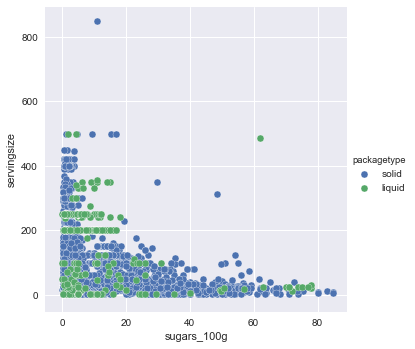

In [34]:
sns.pairplot(x_vars=["sugars_100g"], y_vars=["servingsize"], data=foodfacts, hue="packagetype", size=5)

Looking at the statistical measurements between the two there is little difference between the two.
 - Mean is **10.71** for solids, **9.31** for liquids
 - Standard deviation is **13.94** for solids, **12.28** for liquids

In [35]:
print(foodfacts.loc[ foodfacts['packagetype'] == 'solid' ]['sugars_100g'].describe())
print(foodfacts.loc[ foodfacts['packagetype'] == 'liquid' ]['sugars_100g'].describe())

count    2982.000000
mean       10.712633
std        13.944596
min         0.010000
25%         1.200000
50%         3.900000
75%        14.900000
max        85.000000
Name: sugars_100g, dtype: float64
count    437.000000
mean       9.315378
std       12.286195
min        0.030000
25%        3.600000
50%        5.500000
75%       11.000000
max       78.000000
Name: sugars_100g, dtype: float64


## Question: Is everything bigger and sweeter in the US?
Another common belief is that everything bigger and sweeter than in the US, but is this true?

If we compare visualy the sugar content and serving size again, first for the US and then for France, we get the graphs below.
These are eerily similar.

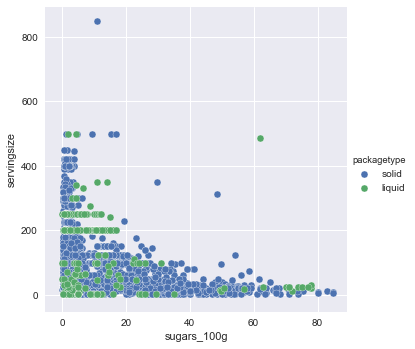

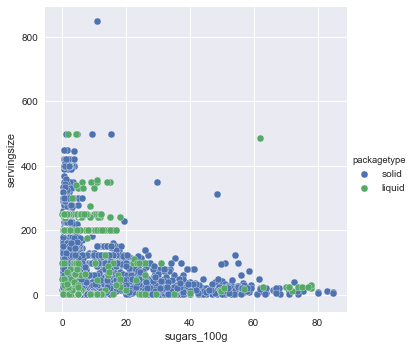

In [36]:
sns.pairplot(x_vars=["sugars_100g"], y_vars=["servingsize"], data=foodfacts.loc[ foodfacts['is_us'] ], hue="packagetype", size=5)
sns.pairplot(x_vars=["sugars_100g"], y_vars=["servingsize"], data=foodfacts.loc[ foodfacts['is_fr'] ], hue="packagetype", size=5)

Either or the answer is no, everything is not bigger and sweeter in the US for there might be something in our data which makes such a comparison difficult.

## Question: What are the similarities shown so far caused by?
Our analysis so far has shown little difference between US and France. Is this caused by brunt of products available are the same? We will merge the two sets based on `code` (unique key for a product), a look which products are available in both US and France.

As you can see in the below graph, the majority of products (92%) is common for both countries.

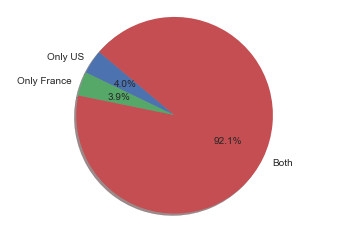

In [40]:
merged = pd.merge(foodfacts.loc[foodfacts["is_us"]], foodfacts.loc[foodfacts["is_fr"]], on=['code'], indicator=True, how='outer')

product_count = [
    merged[ merged['_merge'] == 'right_only' ]['code'].count(),
    merged[ merged['_merge'] == 'left_only' ]['code'].count(),
    merged[ merged['_merge'] == 'both' ]['code'].count()]
labels = ['Only US', 'Only France', 'Both']

plt.pie(product_count, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

## Questions: If we compare products Only available in France with those Only avaialble in the US, is everything bigger and sweeter in the us?
To improve our answer to our question, we should only compare products available in either France or US.

See below illustration and comparing means for suger content and serving size between France and the US


Mean sugar content liquid, France:  9.58
Mean sugar content liquid, US:      6.77
Mean serving size liquid, France:   188.00
Mean serving size liquid, US:       139.79


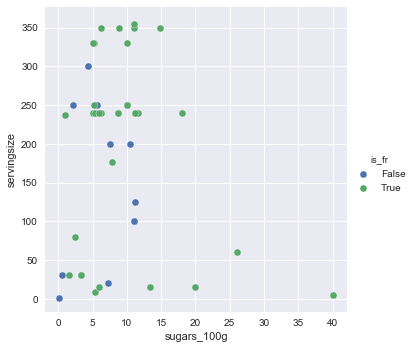

In [96]:
not_common_foodfacts = foodfacts[ ~foodfacts['code'].isin(merged.loc[ merged['_merge'] == 'both' ]['code']) ]

sns.pairplot(x_vars=["sugars_100g"], y_vars=["servingsize"], data=not_common_foodfacts.loc[ (not_common_foodfacts["packagetype"] == 'liquid') ], hue="is_fr", size=5)

print("Mean sugar content liquid, France:  {:0.2f}".format(merged.loc[ (merged['_merge'] == 'right_only') & (merged["packagetype_y"] == 'liquid') ]['sugars_100g_y'].mean()))
print("Mean sugar content liquid, US:      {:0.2f}".format(merged.loc[ (merged['_merge'] == 'left_only') & (merged["packagetype_x"] == 'liquid') ]['sugars_100g_x'].mean()))
print("Mean serving size liquid, France:   {:0.2f}".format(merged.loc[ (merged['_merge'] == 'right_only') & (merged["packagetype_y"] == 'liquid') ]['servingsize_y'].mean()))
print("Mean serving size liquid, US:       {:0.2f}".format(merged.loc[ (merged['_merge'] == 'left_only') & (merged["packagetype_x"] == 'liquid') ]['servingsize_x'].mean()))

Mean sugar content solid, France:   19.34
Mean sugar content solid, US:       14.45
Mean serving size solid, France:    49.39
Mean serving size solid, US:        65.98


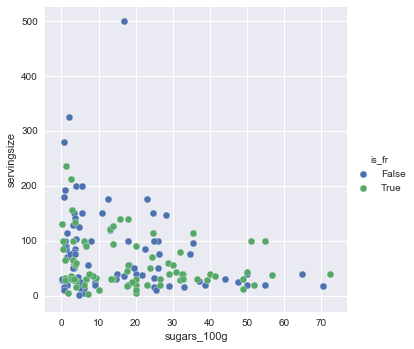

In [97]:
sns.pairplot(x_vars=["sugars_100g"], y_vars=["servingsize"], data=not_common_foodfacts.loc[ (not_common_foodfacts["packagetype"] == 'solid') ], hue="is_fr", size=5)

print("Mean sugar content solid, France:   {:0.2f}".format(merged.loc[ (merged['_merge'] == 'right_only') & (merged["packagetype_y"] == 'solid') ]['sugars_100g_y'].mean()))
print("Mean sugar content solid, US:       {:0.2f}".format(merged.loc[ (merged['_merge'] == 'left_only') & (merged["packagetype_x"] == 'solid') ]['sugars_100g_x'].mean()))
print("Mean serving size solid, France:    {:0.2f}".format(merged.loc[ (merged['_merge'] == 'right_only') & (merged["packagetype_y"] == 'solid') ]['servingsize_y'].mean()))
print("Mean serving size solid, US:        {:0.2f}".format(merged.loc[ (merged['_merge'] == 'left_only') & (merged["packagetype_x"] == 'solid') ]['servingsize_x'].mean()))


Suprisingly, things are sweeter in France for both liquids and solids.
And the US have larger liquid serving sizes, where France has larger solid serving sizes.

## Criticism
Due to unclean data, the number of products compared as small (around 3000 in total). In addition, most of these products are available in both in France and the US. Making a comparison between two markets susceptible to variations in the available product set. Therefore, the conclusion above can only serve as an indication.

## Further research
In this report we've compared sugar content and serving size between two countries based on the dataset [Open Food Facts](https://www.kaggle.com/openfoodfacts/world-food-facts/data).

As we've seen, France and the US share many similarities in food products. And difference between the two countries resulted if very few products.

Further research:
 - Compare other countries from other parts of the world, where product similarities aren't as pronounced.
 - Compare groups of countries (e.g. North America vs Europe vs South east asia)
 - Compare other nutrient types (e.g. carbs, proteins, etc)
